# ANÁLISE EXPLORATÓRIA DOS DADOS


## CONTEXTO

Essa análise tem como objetivo estudar e entender os dados e o comportamento do fechamento do índice Bovespa para a construção de um modelo de machine learning

Está sendo utilizado uma base amostral com o histórico dos ultimos 15 anos do fechamento diário do indice Bovespa

A base de dados bruta pode ser encontrada neste link: https://br.investing.com/indices/bovespa-historical-data

### IMPORTANDO BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.inspection import permutation_importance

# ANALISE EXPLORATÓRIA

In [2]:
# Importando csv para um dataframe
df = pd.read_csv('/content/drive/MyDrive/ESTUDOS/FIAP/FASE 2/Tech Challenger/Dados/Dados Históricos - Ibovespa.csv', sep=',')

In [3]:
# Visualizando primeiras linhas do dataframe
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,31.07.2025,133.071,133.987,133.987,132.096,"9,20B","-0,69%"
1,30.07.2025,133.990,132.702,134.368,131.883,"8,66B","0,95%"
2,29.07.2025,132.726,132.130,133.346,132.130,"6,32B","0,45%"
3,28.07.2025,132.129,133.538,133.902,131.550,"6,63B","-1,04%"
4,25.07.2025,133.524,133.820,134.204,133.285,"5,56B","-0,21%"


In [4]:
# Visualizando informações das colunas do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2502 non-null   object 
 1   Último    2502 non-null   float64
 2   Abertura  2502 non-null   float64
 3   Máxima    2502 non-null   float64
 4   Mínima    2502 non-null   float64
 5   Vol.      2501 non-null   object 
 6   Var%      2502 non-null   object 
dtypes: float64(4), object(3)
memory usage: 137.0+ KB


In [5]:
# Convertendo coluna de data para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')

In [6]:
# Filtrando ultimos 2 anos
#df = df[df['Data'] >= '2023-07-01']

In [7]:
# Verificando se existem dados nulos
df.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,1
Var%,0


In [8]:
# Removendo linha com volume vázio
df = df[~df['Vol.'].isnull()]

In [9]:
# Verificando se na coluna de volume existe outra unidade de medida além de bilhões
set(df['Vol.'].str[-1])

{'B', 'K', 'M'}

In [10]:
# Criando função pra mudar o formatado do volume para float
def transformar_volume_em_float(row):
    vol = str(row['Vol.']).replace(',', '.')
    if 'B' in vol:
        return float(vol.replace('B', '')) * 1000000000 # Multiplicando por um bilhão
    elif 'M' in vol:
        return float(vol.replace('M', '')) * 1000000 # Multiplicando por um milhão
    elif 'K' in vol:
        return float(vol.replace('K', '')) * 1000 # Multiplicando por um mil
    else:
        return None

df['Vol.'] = df.apply(transformar_volume_em_float, axis=1)

In [11]:
# Transformando a coluna de variação em float
df.loc[:,'Var%'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float) / 100

In [12]:
# Trazendo informações basicas de estátisticas
df.describe()

,Data,Último,Abertura,Máxima,Mínima,Vol.
count,2501,2501.000000,2501.000000,2501.000000,2501.000000,2.501000e+03
mean,2020-07-20 06:11:56.833266688,96.437958,96.406582,97.258151,95.583375,5.726745e+08
min,2015-07-01 00:00:00,37.497000,37.501000,38.031000,37.046000,4.243200e+05
25%,2018-01-11 00:00:00,74.712000,74.687000,75.680000,74.196000,3.960000e+06
50%,2020-07-23 00:00:00,102.933000,102.930000,104.041000,102.046000,7.810000e+06
75%,2023-01-26 00:00:00,117.904000,117.893000,118.792000,116.953000,1.132000e+07
max,2025-07-31 00:00:00,141.264000,141.265000,141.564000,140.597000,2.487000e+10
std,NaN,26.800114,26.804090,26.893703,26.701079,2.391685e+09


In [13]:
# Criando coluna de mês/ano
df['MesAno'] = pd.to_datetime(df['Data'].dt.strftime('%Y-%m'))

In [14]:
# Agrupando valores por mes/ano
df_agrupado_mes = df.groupby('MesAno')[['Último','Abertura','Máxima','Mínima']].mean()
df_agrupado_mes.head()

,Último,Abertura,Máxima,Mínima
MesAno,,,,
2015-07-01,51.559500,51.659909,52.032409,51.128545
2015-08-01,47.687667,47.888048,48.317333,47.137381
2015-09-01,46.314714,46.390000,46.896381,45.776905
2015-10-01,47.281762,47.244143,47.793524,46.757238
2015-11-01,47.089895,47.127895,47.599368,46.614947


Text(0.5, 1.0, 'Indice Ibovespa ao longo do tempo')

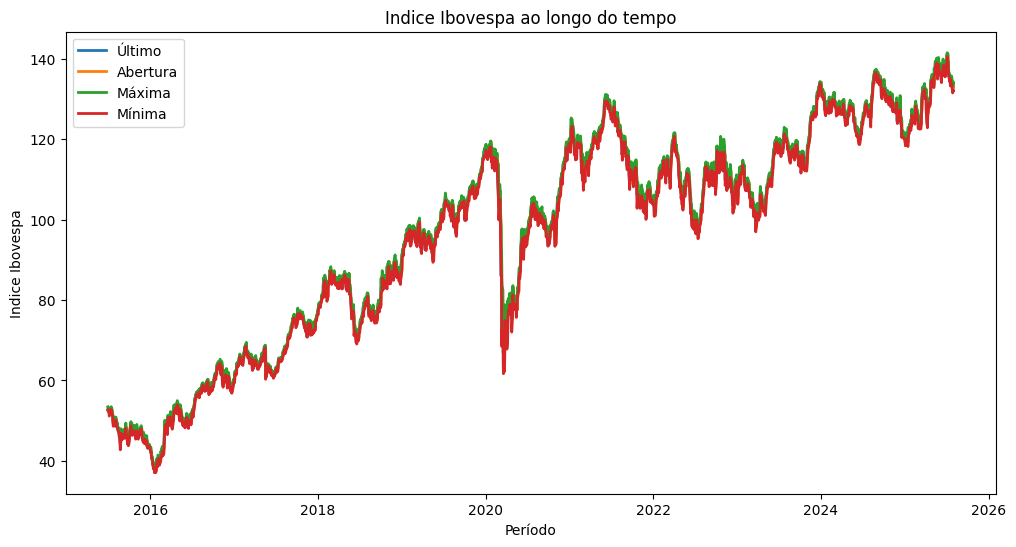

In [15]:
# Criando gráfico de indice ibovespa ao longo do tempo
df.set_index('Data', inplace=True)
df.sort_index()
plt.figure(figsize=(12,6))

for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    plt.plot(df.index, df[col], label=col, linewidth=2)

plt.xlabel('Período')
plt.ylabel('Indice Ibovespa')
plt.legend(loc='best')
plt.title('Indice Ibovespa ao longo do tempo')

Text(0.5, 1.0, 'Volume Ibovespa ao longo do tempo')

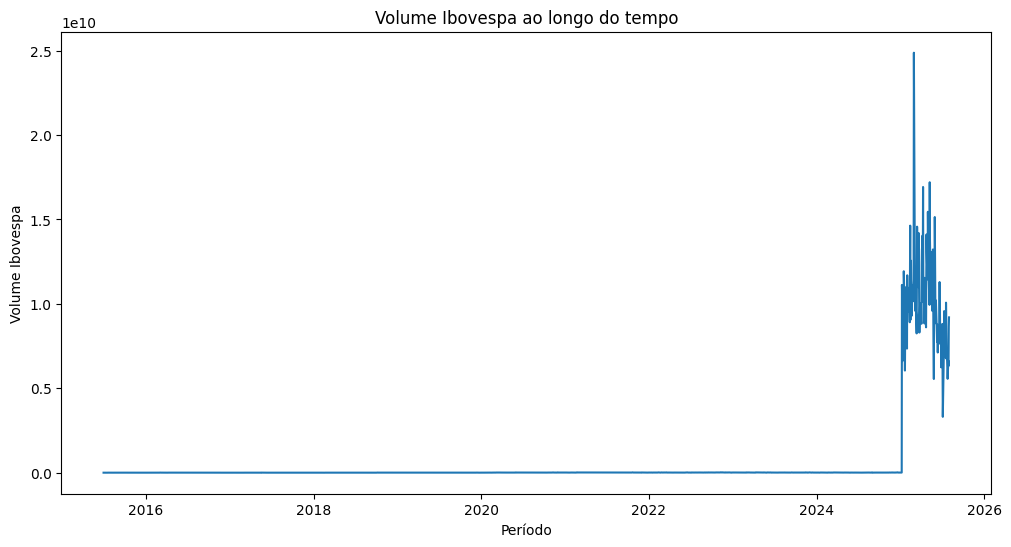

In [16]:
# Criando gráfico de Volume ibovespa ao longo do tempo
plt.figure(figsize=(12,6))

plt.plot(df['Vol.'])

plt.xlabel('Período')
plt.ylabel('Volume Ibovespa')
plt.title('Volume Ibovespa ao longo do tempo')

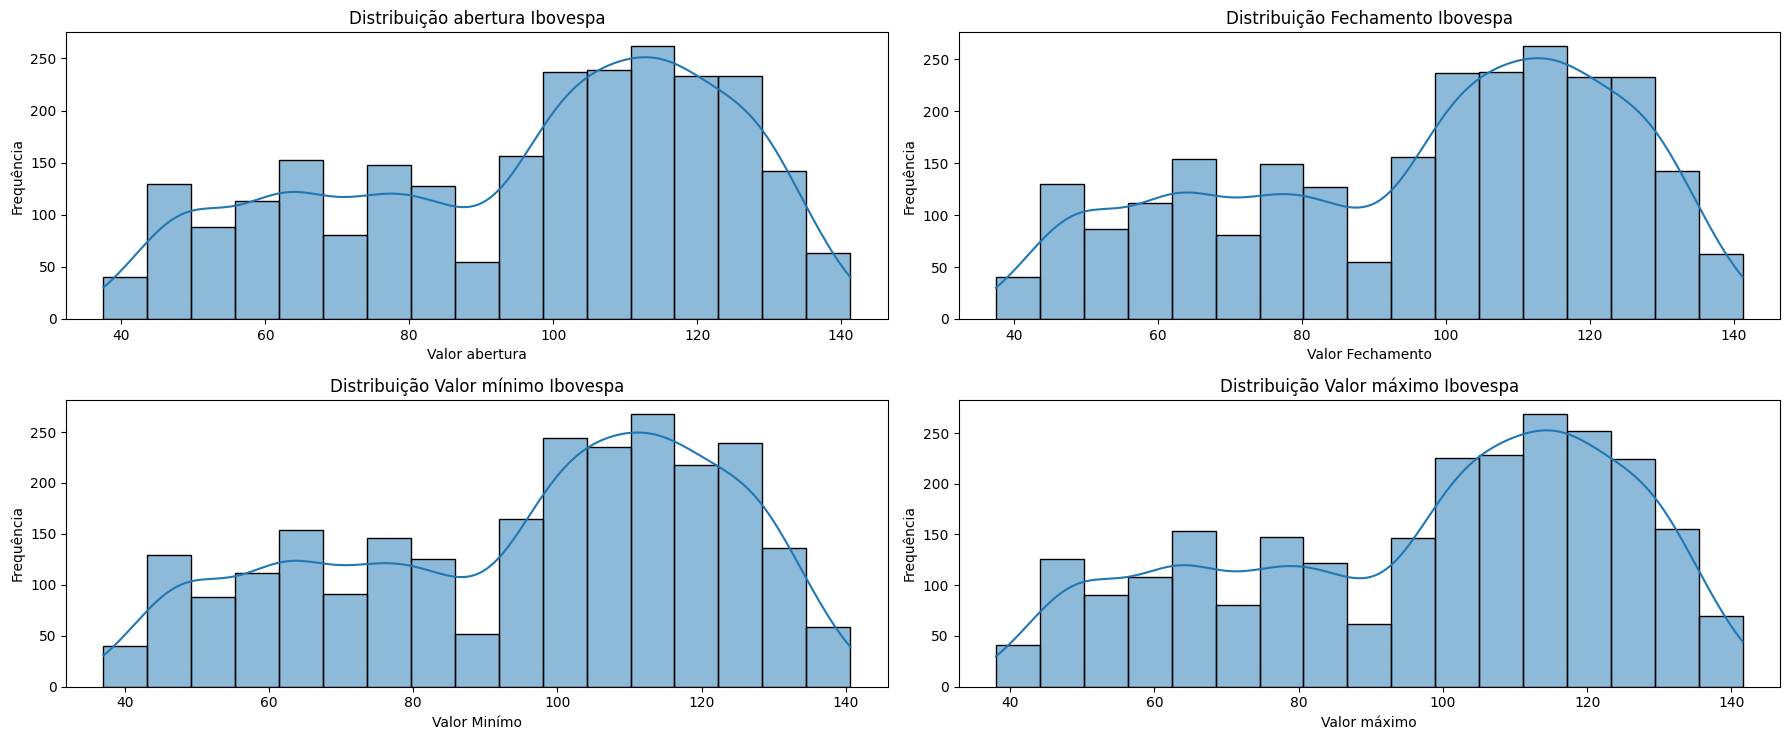

In [17]:
# Criando histograma para analisar frequências
fig, axes = plt.subplots(2, 2, figsize=(18,7.5))
axes = axes.flatten()

sns.histplot(data=df, x='Abertura', kde=True, ax=axes[0])
axes[0].set_title('Distribuição abertura Ibovespa')
axes[0].set_xlabel('Valor abertura')
axes[0].set_ylabel('Frequência')

sns.histplot(data=df, x='Último', kde=True, ax=axes[1])
axes[1].set_title('Distribuição Fechamento Ibovespa')
axes[1].set_xlabel('Valor Fechamento')
axes[1].set_ylabel('Frequência')


sns.histplot(data=df, x='Mínima', kde=True, ax=axes[2])
axes[2].set_title('Distribuição Valor mínimo Ibovespa')
axes[2].set_xlabel('Valor Minímo')
axes[2].set_ylabel('Frequência')

sns.histplot(data=df, x='Máxima', kde=True, ax=axes[3])
axes[3].set_title('Distribuição Valor máximo Ibovespa')
axes[3].set_xlabel('Valor máximo')
axes[3].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [18]:
# Testando hipótese de normalidade de frequências para variáveis do indice Ibovespa
stat, p = shapiro(df['Último'])
print('Valores de fechamento índice Ibovespa:')
print('Estatística de teste: {:.4f}, valor p: {}'.format(stat, p))

if p > 0.05:
  print('Não há evidência suficiente para rejeitar a hipótese de normalidade')
else:
  print('A hipótese de normalidade é rejeitada')
  print('Como todos os gráficos tem distribuições semelhantes, é possivel concluir o mesmo resultado para todos.')

Valores de fechamento índice Ibovespa:
Estatística de teste: 0.9407, valor p: 1.4958284626878264e-30
A hipótese de normalidade é rejeitada
Como todos os gráficos tem distribuições semelhantes, é possivel concluir o mesmo resultado para todos.


In [19]:
# Testando hipótese de comparação estátiscas entre as variáveis
stat, p = mannwhitneyu(
    df['Abertura'].sample(len(df['Abertura']), random_state=7),
    df['Último'].sample(len(df['Último']), random_state=7),
    alternative='less')

print('Analise estátistica entre Valor de abertura e valor de fechamento do índice Ibovespa:')
print('Estatística de teste U: ', stat)
print('Valor p: {}'.format(p))

alpha = 0.05

if p < alpha:
  print('Diferença estatiscamente significante')
else:
  print('Não há diferença estatiscamente significante')

Analise estátistica entre Valor de abertura e valor de fechamento do índice Ibovespa:
Estatística de teste U:  3125529.5
Valor p: 0.4846099357581282
Não há diferença estatiscamente significante


In [20]:
# Testando hipótese de comparação estátiscas entre as variáveis
stat, p = mannwhitneyu(
    df['Mínima'].sample(len(df['Mínima']), random_state=7),
    df['Máxima'].sample(len(df['Máxima']), random_state=7),
    alternative='less')

print('Analise estátistica entre Valor de Mínima e valor de máxima do índice Ibovespa:')
print('Estatística de teste U: ', stat)
print('Valor p: {}'.format(p))

alpha = 0.05

if p < alpha:
  print('Diferença estatiscamente significante')
else:
  print('Não há diferença estatiscamente significante')

Analise estátistica entre Valor de Mínima e valor de máxima do índice Ibovespa:
Estatística de teste U:  2992850.5
Valor p: 0.004185414133046876
Diferença estatiscamente significante


In [21]:
# Reduzindo as frequências de volume para gráfico de histograma
df['Vol. Sqrt'] = np.sqrt(df['Vol.'])

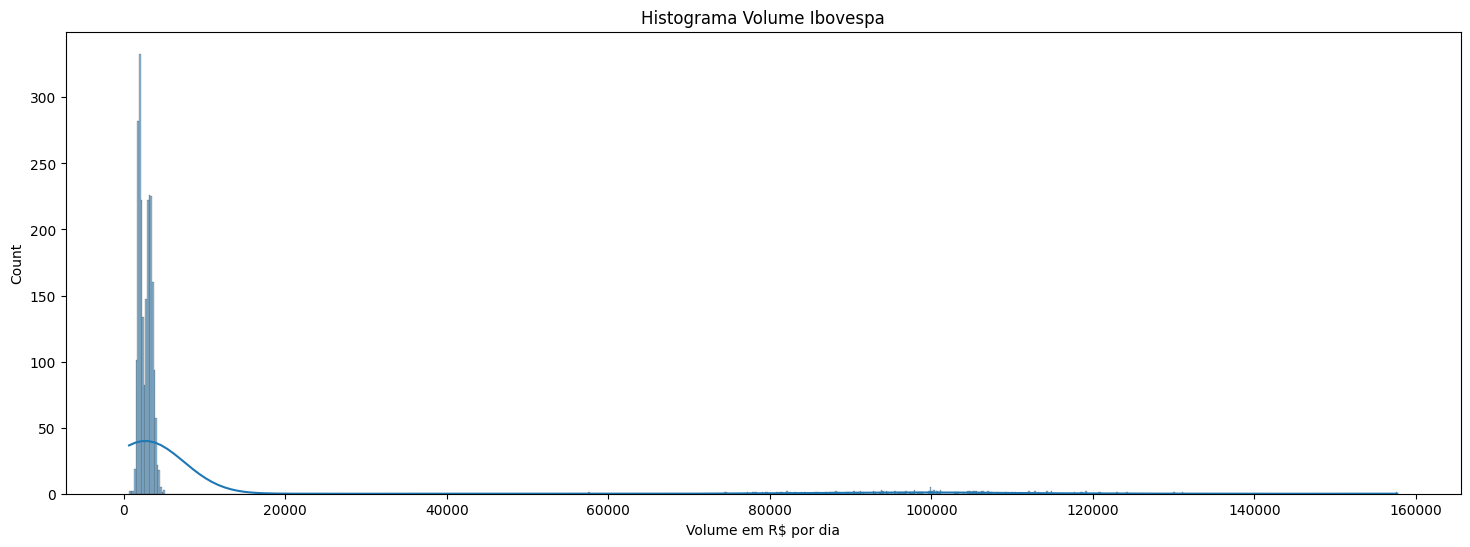

In [22]:
# Criando histograma para entender a distribuição do volume

plt.figure(figsize=(18, 6))

sns.histplot(data=df, x='Vol. Sqrt', kde=True)
plt.xlabel('Volume em R$ por dia')
plt.title('Histograma Volume Ibovespa')

plt.show()

In [23]:
# Testando hipótese de normalidade de frequências para volume do indice Ibovespa
stat, p = shapiro(df['Vol.'])
print('Volume índice Ibovespa:')
print('Estatística de teste: {:.4f}, valor p: {}'.format(stat, p))

if p > 0.05:
  print('Não há evidência suficiente para rejeitar a hipótese de normalidade')
else:
  print('A hipótese de normalidade é rejeitada')

Volume índice Ibovespa:
Estatística de teste: 0.2496, valor p: 3.1338247190575155e-72
A hipótese de normalidade é rejeitada


É possível entender que a distribuição entre as datas são assimétricas

É possível identificar que na variável de Volume existe uma grande destorção das frequências (outliers)

Text(0.5, 1.0, 'Variação Indice Ibovespa ao longo do tempo')

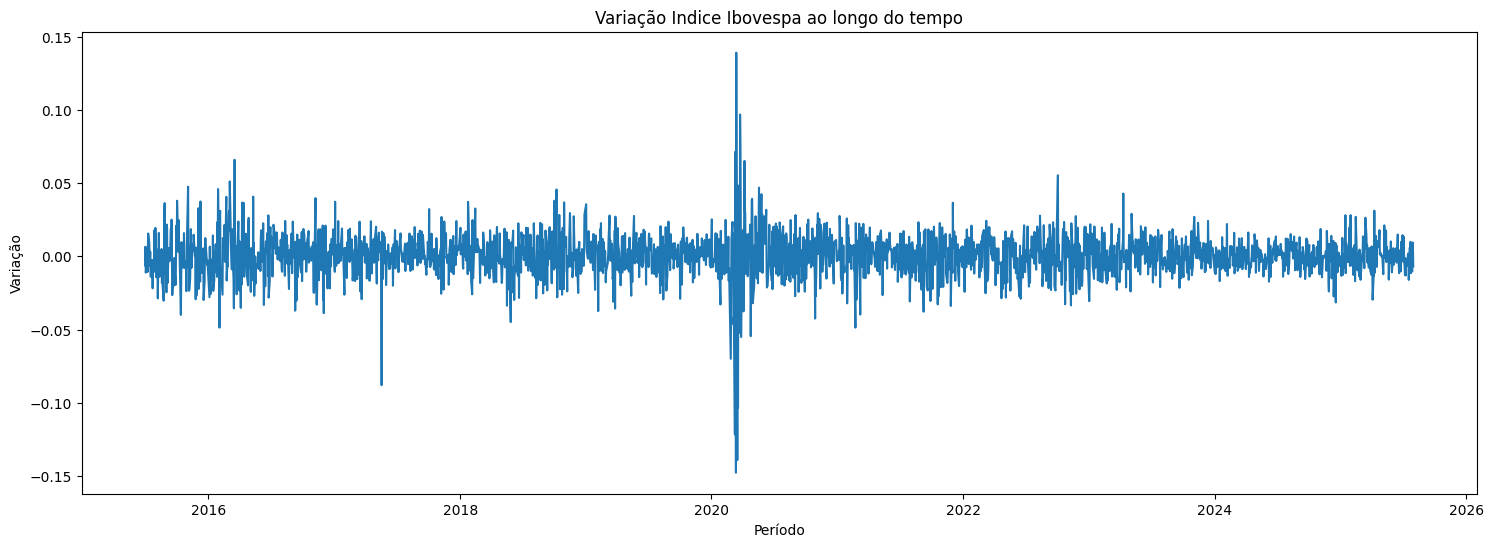

In [24]:
# Criando gráfico de variação do indice ibovespa ao longo do tempo
plt.figure(figsize=(18,6))

plt.plot(df['Var%'])

plt.xlabel('Período')
plt.ylabel('Variação')
plt.title('Variação Indice Ibovespa ao longo do tempo')

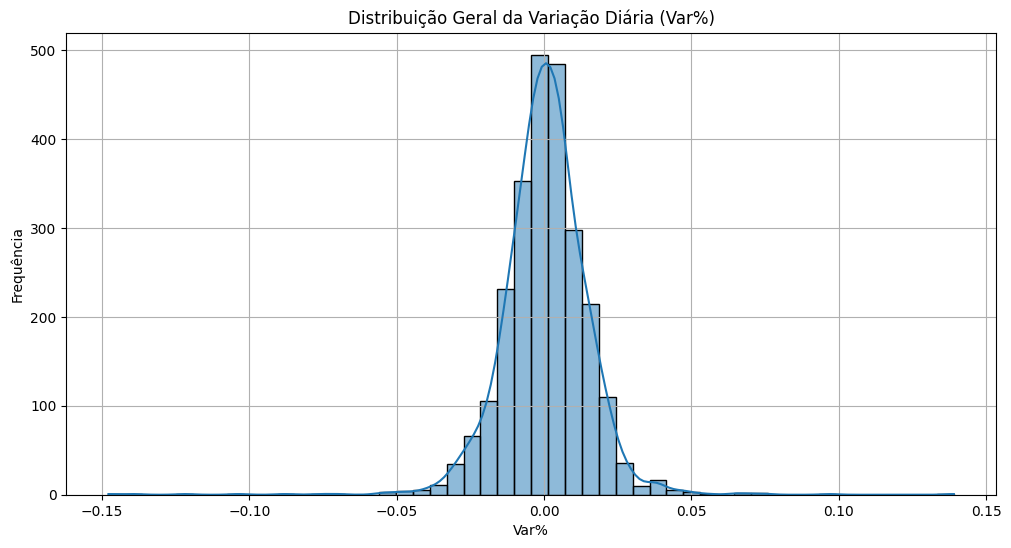

In [25]:
# Histograma com curva de densidade (distribuição da variação diária)
plt.figure(figsize=(12, 6))
sns.histplot(df['Var%'], bins=50, kde=True)
plt.title('Distribuição Geral da Variação Diária (Var%)')
plt.xlabel('Var%')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

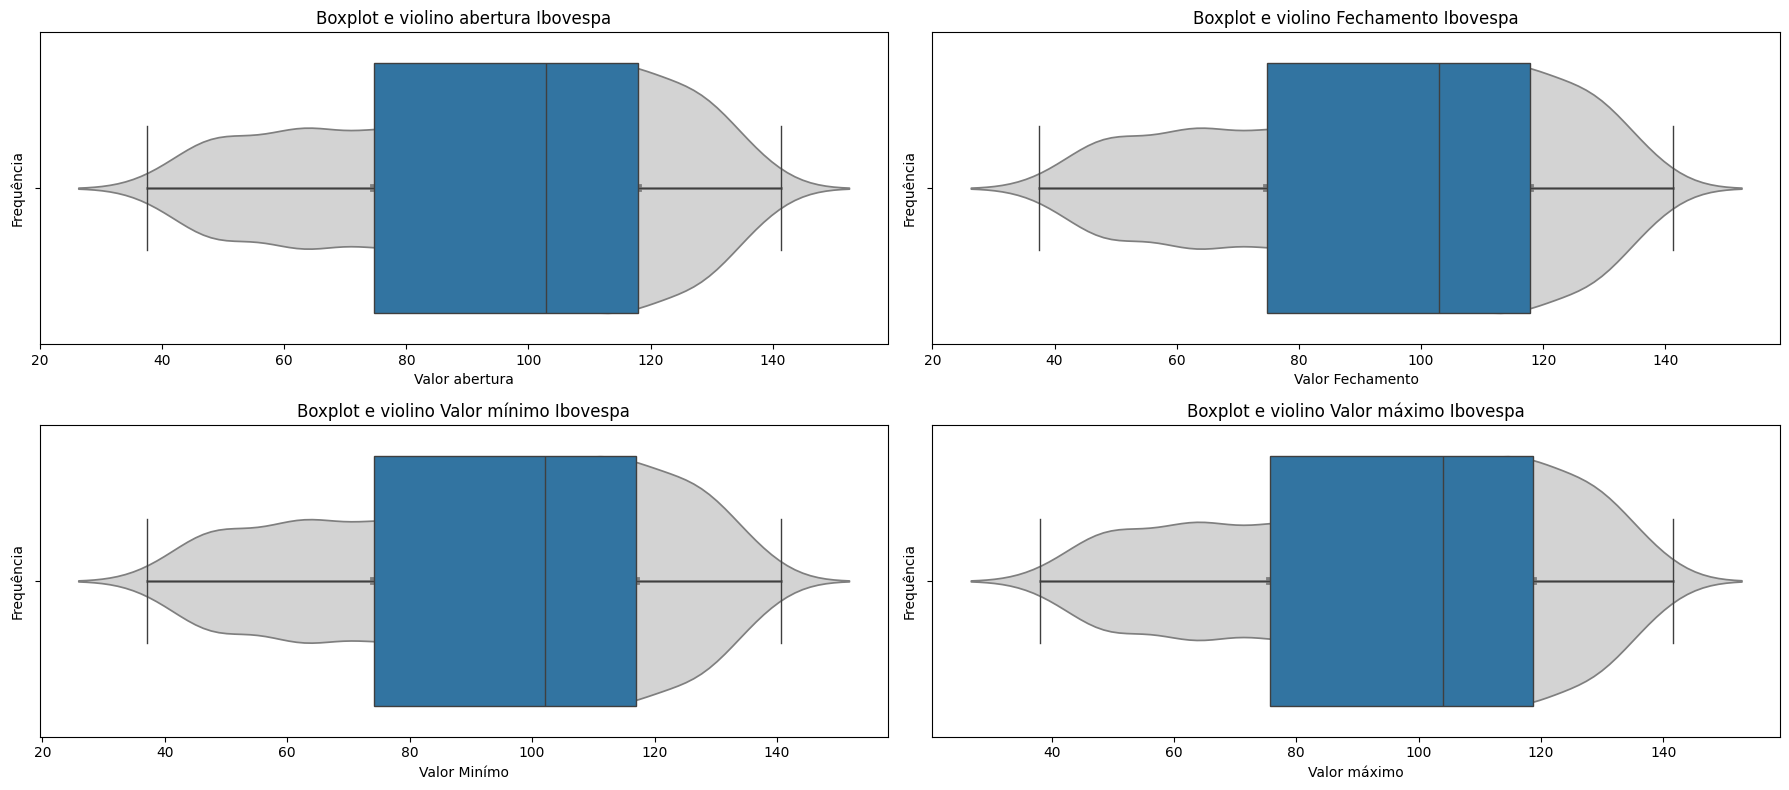

In [26]:
# Criando gráficos de violino e boxplot para analisar outliers
fig, axes = plt.subplots(2, 2, figsize=(18,8))
axes = axes.flatten()

sns.violinplot(x='Abertura', data=df, ax=axes[0], color='lightgray')
sns.boxplot(x='Abertura', data=df, ax=axes[0], whis=1.5)
axes[0].set_title('Boxplot e violino abertura Ibovespa')
axes[0].set_xlabel('Valor abertura')
axes[0].set_ylabel('Frequência')

sns.violinplot(x='Último', data=df, ax=axes[1], color='lightgray')
sns.boxplot(x='Último', data=df, ax=axes[1], whis=1.5)
axes[1].set_title('Boxplot e violino Fechamento Ibovespa')
axes[1].set_xlabel('Valor Fechamento')
axes[1].set_ylabel('Frequência')

sns.violinplot(x='Mínima', data=df, ax=axes[2], color='lightgray')
sns.boxplot(x='Mínima', data=df, ax=axes[2], whis=1.5)
axes[2].set_title('Boxplot e violino Valor mínimo Ibovespa')
axes[2].set_xlabel('Valor Minímo')
axes[2].set_ylabel('Frequência')

sns.violinplot(x='Máxima', data=df, ax=axes[3], color='lightgray')
sns.boxplot(x='Máxima', data=df, ax=axes[3], whis=1.5)
axes[3].set_title('Boxplot e violino Valor máximo Ibovespa')
axes[3].set_xlabel('Valor máximo')
axes[3].set_ylabel('Frequência')


plt.tight_layout()
plt.show()

In [27]:
# Criando variável de fechamento em alta
df['Class'] = [1 if v > 0 else 0 for v in df['Var%']]

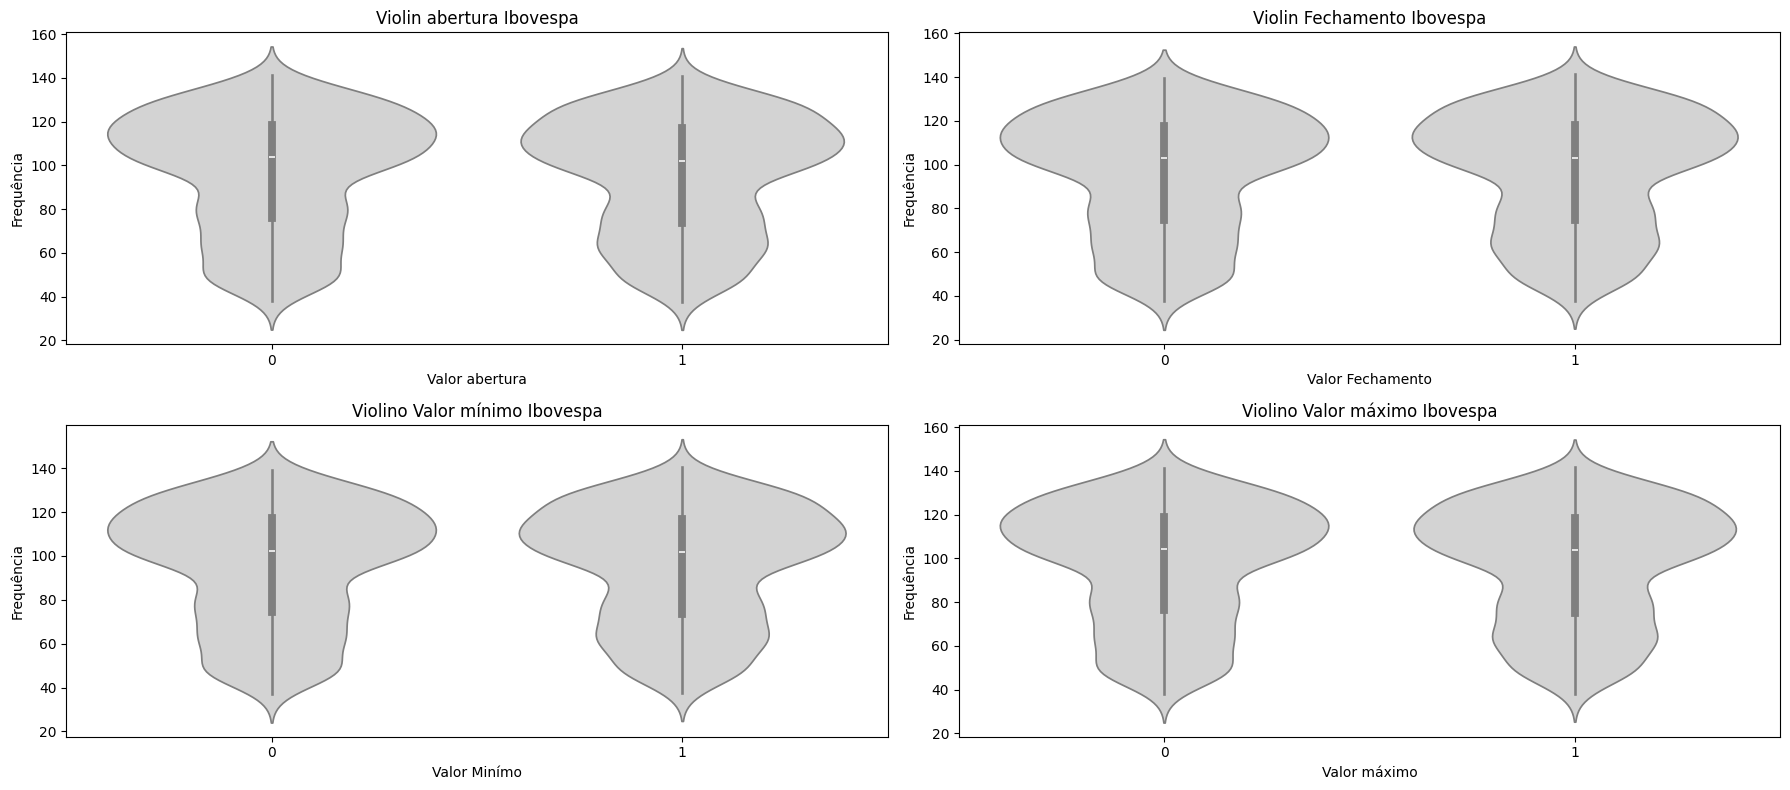

In [28]:
# Criando gráficos de violino para entender comportamento das variáveis quando o indice fecha em alta ou em baixa
fig, axes = plt.subplots(2, 2, figsize=(18,8))
axes = axes.flatten()

sns.violinplot(x='Class', y='Abertura', data=df, ax=axes[0], color='lightgray')
axes[0].set_title('Violin abertura Ibovespa')
axes[0].set_xlabel('Valor abertura')
axes[0].set_ylabel('Frequência')

sns.violinplot(x='Class', y='Último', data=df, ax=axes[1], color='lightgray')
axes[1].set_title('Violin Fechamento Ibovespa')
axes[1].set_xlabel('Valor Fechamento')
axes[1].set_ylabel('Frequência')

sns.violinplot(x='Class', y='Mínima', data=df, ax=axes[2], color='lightgray')
axes[2].set_title('Violino Valor mínimo Ibovespa')
axes[2].set_xlabel('Valor Minímo')
axes[2].set_ylabel('Frequência')

sns.violinplot(x='Class', y='Máxima', data=df, ax=axes[3], color='lightgray')
axes[3].set_title('Violino Valor máximo Ibovespa')
axes[3].set_xlabel('Valor máximo')
axes[3].set_ylabel('Frequência')


plt.tight_layout()
plt.show()

<Axes: xlabel='Class', ylabel='count'>

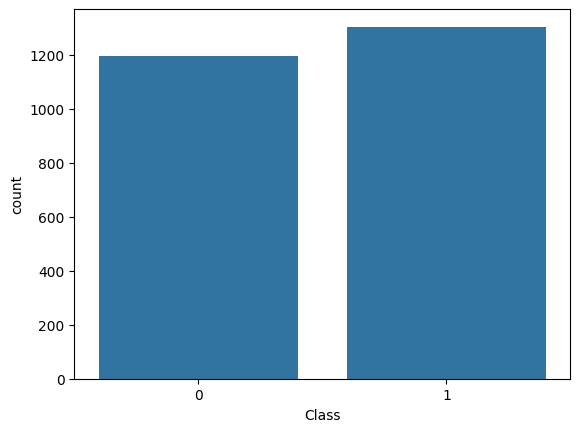

In [29]:
# Verificando balanceamento da classe dos dados
sns.countplot(x='Class', data=df)

In [30]:
# Criando matriz de correlação
correlation_matrix = df.corr(numeric_only=True)

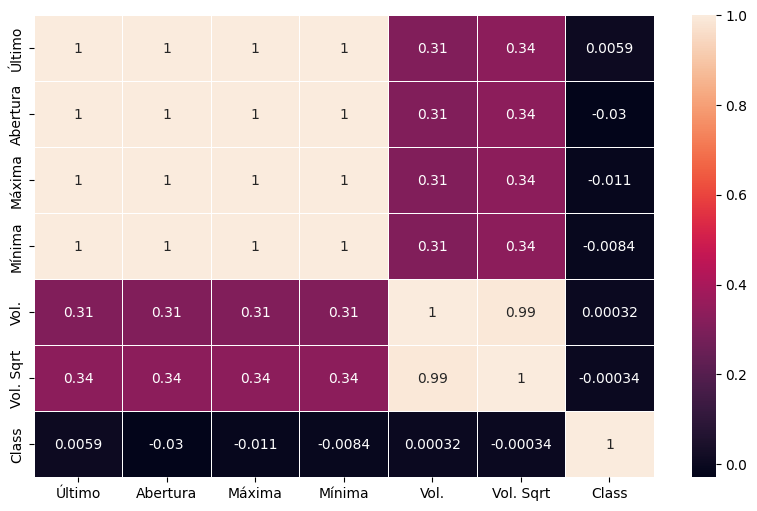

In [31]:
fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

plt.show()

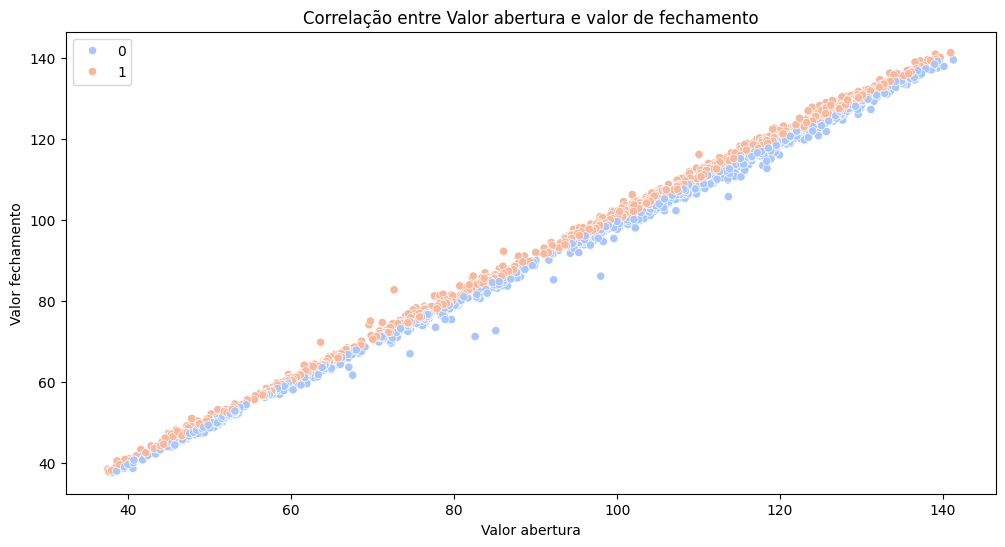

In [32]:
# Criando gráfico de dispersão entre Valor de Abertura e fechamento índice Ibovespa
plt.figure(figsize=(12,6))
sns.scatterplot(x='Abertura', y='Último', hue='Class', data=df, palette='coolwarm')
plt.xlabel('Valor abertura')
plt.ylabel('Valor fechamento')
plt.title('Correlação entre Valor abertura e valor de fechamento')
plt.legend(loc='best')

plt.show()

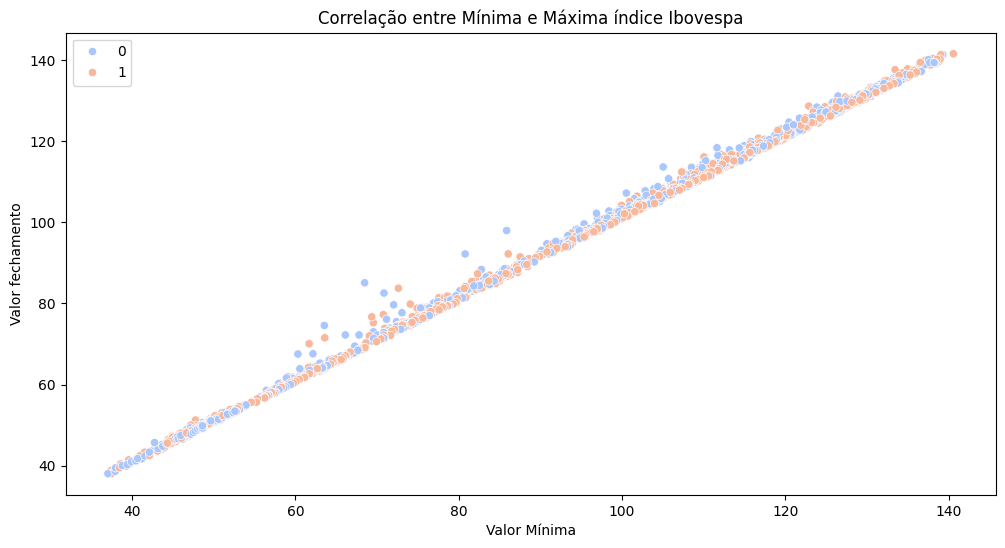

In [33]:
# Criando gráfico de dispersão entre Mínima e Máxima do índice Ibovespa
plt.figure(figsize=(12,6))
sns.scatterplot(x='Mínima', y='Máxima', hue='Class', data=df, palette='coolwarm')
plt.xlabel('Valor Mínima')
plt.ylabel('Valor fechamento')
plt.title('Correlação entre Mínima e Máxima índice Ibovespa')
plt.legend(loc='best')

plt.show()

# FEATURES ENGINEERING

In [34]:
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,MesAno,Vol. Sqrt,Class
Data,,,,,,,,,
2025-07-31,133.071,133.987,133.987,132.096,9.200000e+09,-0.0069,2025-07-01,95916.630466,0
2025-07-30,133.990,132.702,134.368,131.883,8.660000e+09,0.0095,2025-07-01,93059.120993,1
2025-07-29,132.726,132.130,133.346,132.130,6.320000e+09,0.0045,2025-07-01,79498.427657,1
2025-07-28,132.129,133.538,133.902,131.550,6.630000e+09,-0.0104,2025-07-01,81424.811943,0
2025-07-25,133.524,133.820,134.204,133.285,5.560000e+09,-0.0021,2025-07-01,74565.407529,0


In [35]:
# Criando Feature com a variação dentro do dia
df['retorno_intradiario'] = (df['Máxima'] - df['Mínima']) / df['Abertura']
df['variação_dia'] = df['Máxima'] - df['Mínima']
df['gap_abertura'] = df['Abertura'] - df['Último'].shift(1)

In [36]:
# Criando Features de Médias móveis
df['mm15_abertura'] = df['Abertura'].rolling(window=15).mean()
df['mm3_abertura'] = df['Abertura'].rolling(window=3).mean()
df['mm5_abertura'] = df['Abertura'].rolling(window=5).mean()
df['mm3_ultimo'] = df['Último'].rolling(window=3).mean()
df['sinal_cruzamento_mm'] = (df['mm5_abertura'] > df['mm15_abertura']).astype(int)

In [37]:
# Criando Features de tendência
df['tendencia_abertura'] = (df['Abertura'] > df['mm3_abertura']).astype(int)
df['tendencia_ultimo'] = (df['Último'] > df['mm3_ultimo']).astype(int)
df['tendencia_abertura_pct'] = (df['Abertura'] - df['mm3_abertura']) / df['mm3_abertura']

In [38]:
# Criando Features com desvio padrão e volatilidade
df['std5_abertura'] = df['Abertura'].rolling(window=5).std()
df['volatilidade_3d'] = df['Último'].rolling(window=3).std()
df['volatilidade_intradiaria'] = (df['Máxima'] - df['Mínima']) / df['Abertura']

In [39]:
# Criando Features com a diferença absoluta da abertura em relação ao dia anterior
df['dif_abertura_5dia_ant'] = df['Abertura'] - df['Abertura'].shift(5)

In [40]:
# Outras Features
df['aumento_volume'] = df['Vol.'].pct_change()
df['retorno_abertura_5d'] = df['Abertura'].pct_change(periods=5)

In [41]:
# Removendo linhas vazias
df_derivadas = df.dropna()

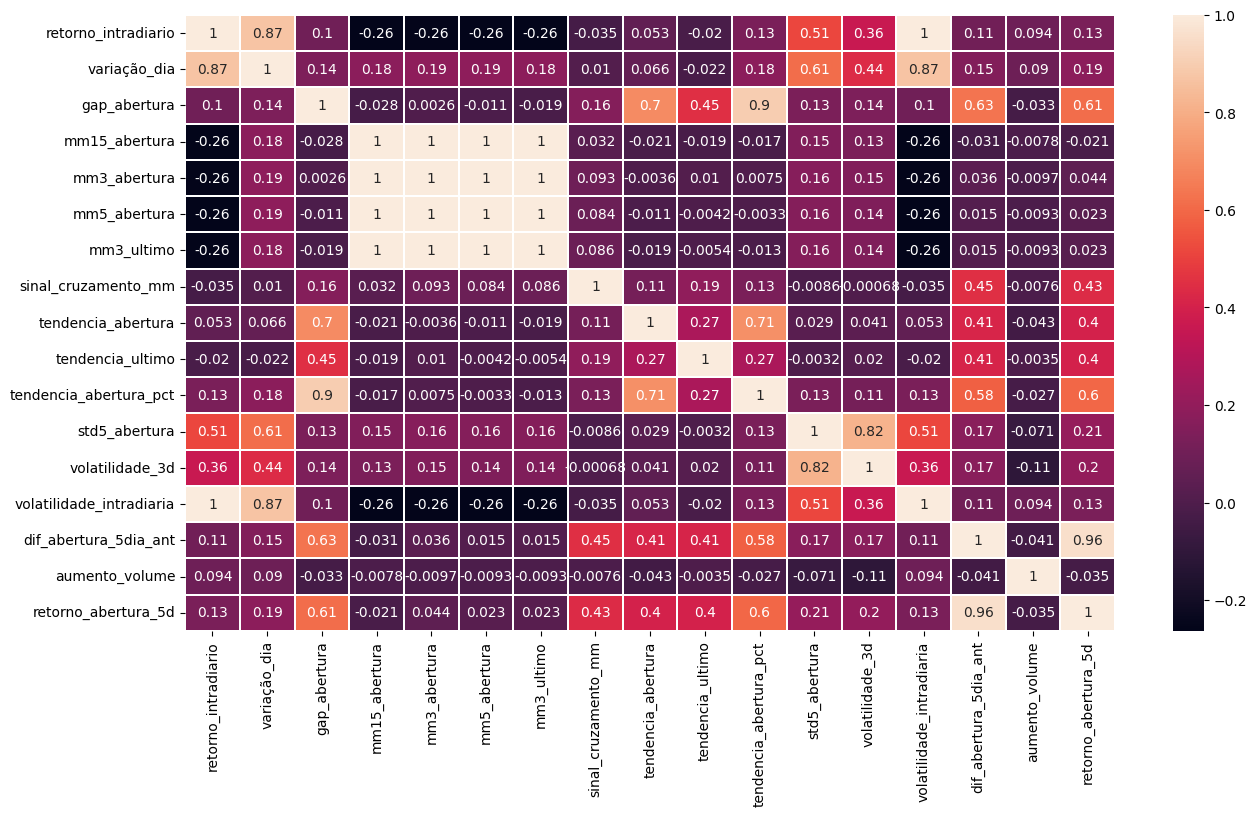

In [42]:
# Visualizando correlação entre as novas variáveis
df_features_derivadas = df_derivadas.drop(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'MesAno','Vol. Sqrt', 'Class'],axis=1)
fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(data=df_features_derivadas.corr(numeric_only=True), annot=True, linewidths=.3, ax=ax)

plt.show()

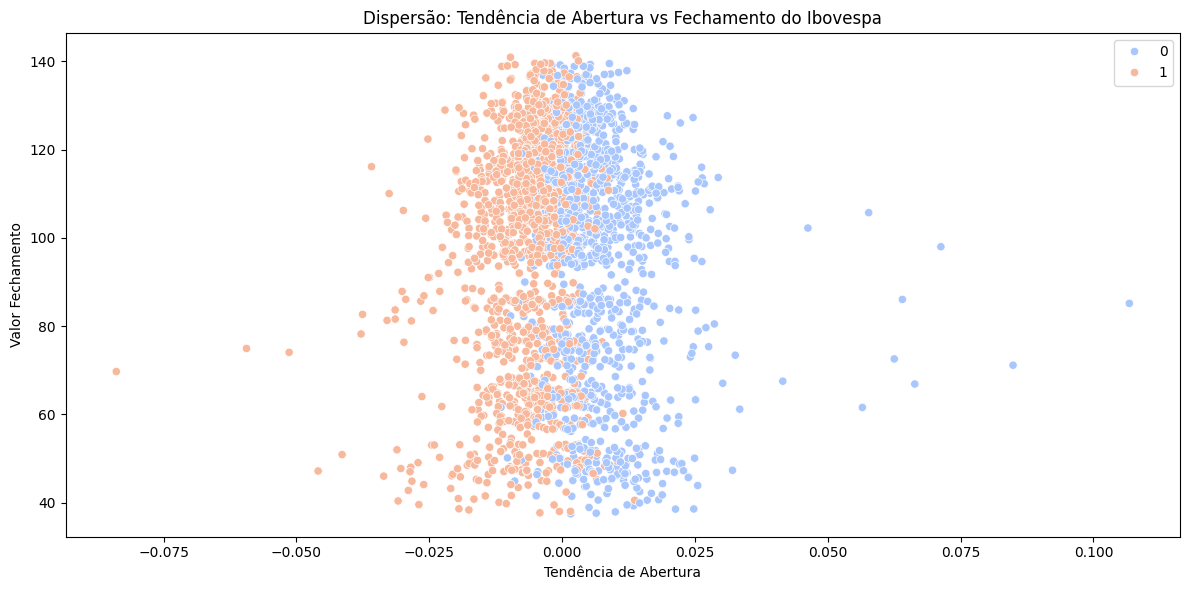

In [43]:
# Criando gráfico de dispersão entre Valor de têndencia e fechamento índice Ibovespa
plt.figure(figsize=(12,6))

sns.scatterplot( x='tendencia_abertura_pct', y='Último', hue='Class', data=df_derivadas, palette='coolwarm')

plt.xlabel('Tendência de Abertura')
plt.ylabel('Valor Fechamento')
plt.title('Dispersão: Tendência de Abertura vs Fechamento do Ibovespa')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

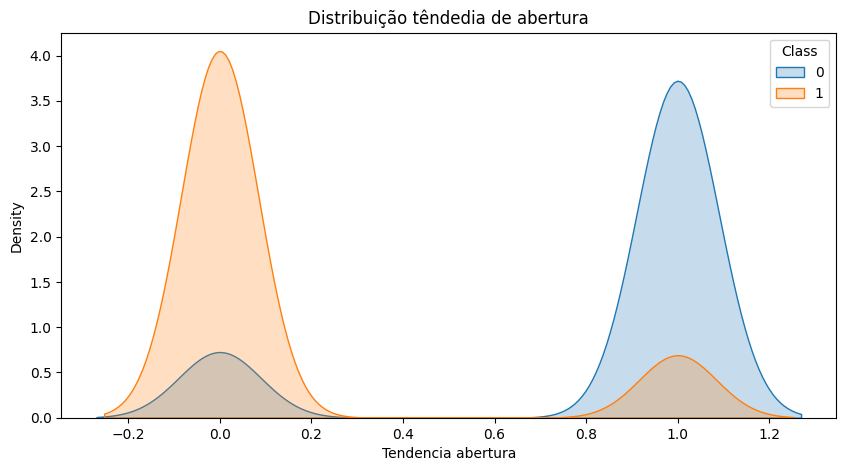

In [44]:
# Criando gráfico de densidade para entender comportamento da tendência
df_class_true = df_derivadas[ df_derivadas['Class'] == 1]
df_class_false = df_derivadas[ df_derivadas['Class'] == 0]
plt.figure(figsize=(10,5))

sns.kdeplot(data=df_class_false, x='tendencia_abertura', label='0', fill=True)
sns.kdeplot(data=df_class_true, x='tendencia_abertura', label='1', fill=True)

plt.title('Distribuição têndedia de abertura')
plt.xlabel('Tendencia abertura')
plt.legend(title='Class')

plt.show()

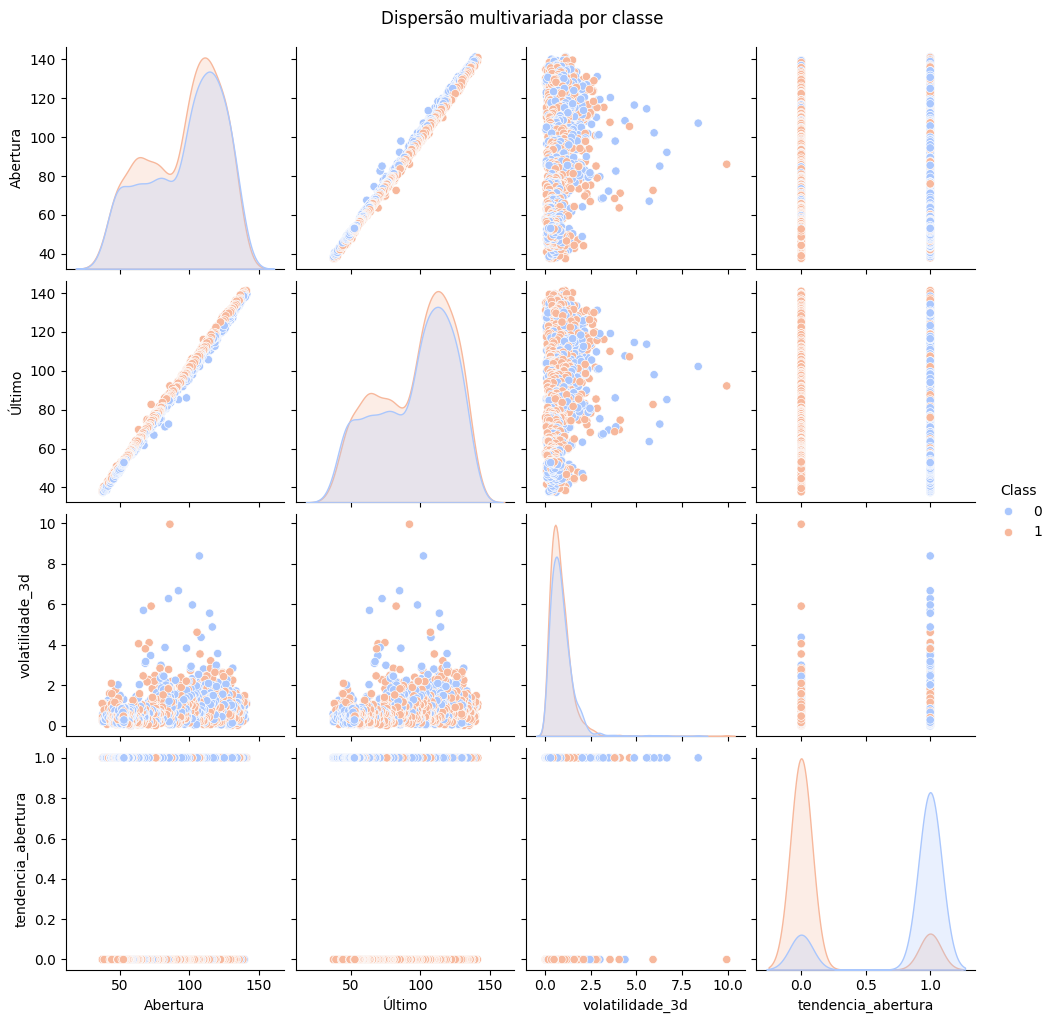

In [45]:
# Criando gráfico de correlação entre as variáveis
sns.pairplot(df[['Abertura', 'Último', 'volatilidade_3d', 'tendencia_abertura', 'Class']], hue='Class', palette='coolwarm')
plt.suptitle('Dispersão multivariada por classe', y=1.02)
plt.show()

In [46]:
# Separando variáveis indepentes e target

x = df_derivadas[[
    'retorno_abertura_5d',
    'tendencia_abertura',
    'volatilidade_3d',
    'gap_abertura',
    'std5_abertura',
    'mm5_abertura',
    'mm15_abertura',
    'variação_dia',
    'sinal_cruzamento_mm'
    ]]
y= df_derivadas['Class']

## MODELOS DE CLASSIFICAÇÃO

### NAIVE BASE

In [47]:
# Dividindo dados entre treino e teste por uma seed aleatória
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [48]:
# Instanciando e treinando modelo
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

In [49]:
# Rodando modelo
y_pred_gnb = gnb.predict(x_test)

In [50]:
# Validando modelo
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)

print('Acurracy: {:.2f}'.format(round(accuracy_gnb, 2)))

Acurracy: 0.84


#### VALIDANDO MODELO

#### VALIDAÇÃO CRUZADA

In [51]:
# Embaralhando dados e rodando testes
kfold = KFold(n_splits=5, shuffle=True )
result_cross_val_gnb = cross_val_score(gnb, x, y, cv=kfold, scoring='accuracy')

# Exibindo resultados
print("Scores de cada fold:", result_cross_val_gnb)
print("R² médio: {:.2f}%".format(result_cross_val_gnb.mean() * 100))
print("Desvio padrão: {:.2f}%".format(result_cross_val_gnb.std() * 100))

Scores de cada fold: [0.81927711 0.8373494  0.84507042 0.85513078 0.84507042]
R² médio: 84.04%
Desvio padrão: 1.20%


#### VISUALIZANDO MÉTRICAS DE VALIDAÇÃO

In [52]:
# Métricas de validação
probs_gnb = gnb.predict_proba(x_test)[:, 1]
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
reports_gnb = classification_report(y_test, y_pred_gnb)
matriz_gnb = confusion_matrix(y_test, y_pred_gnb)
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, probs_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
result_gnb = permutation_importance(gnb, x_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
importances_gnb = result_gnb.importances_mean

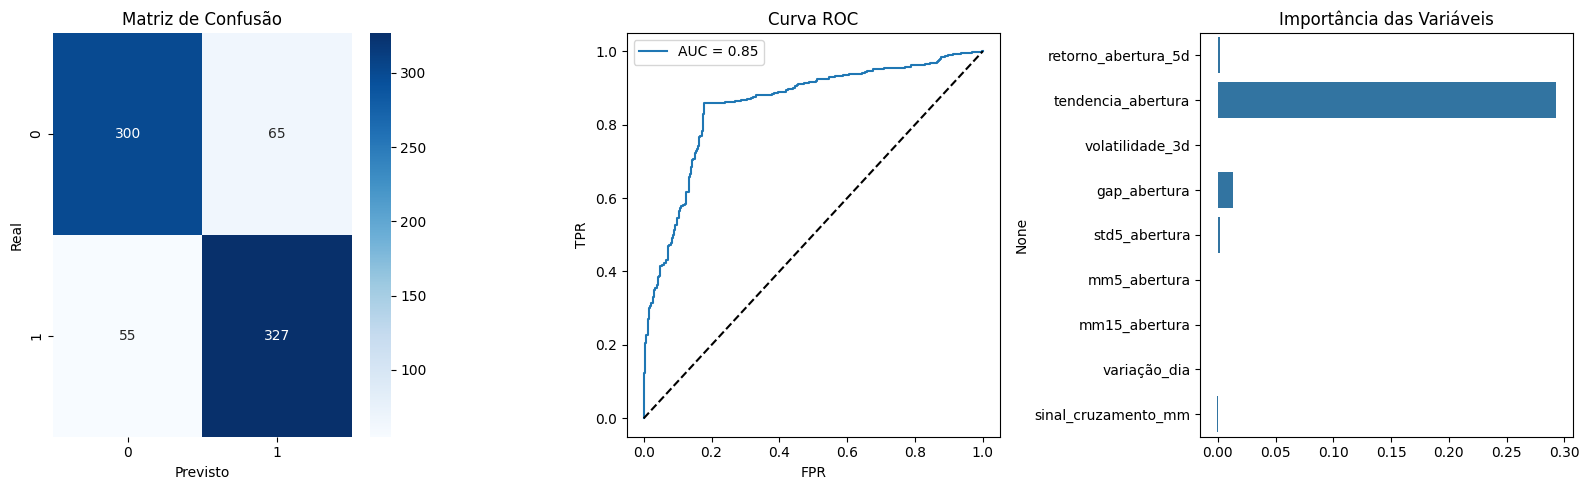

In [53]:
# Gráficos de validação do modelo
plt.figure(figsize=(16, 5))

# Matriz de confusão
plt.subplot(1, 3, 1)
sns.heatmap(matriz_gnb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')

# Curva ROC
plt.subplot(1, 3, 2)
plt.plot(fpr_gnb, tpr_gnb, label=f'AUC = {roc_auc_gnb:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# Importância das variáveis
plt.subplot(1, 3, 3)
sns.barplot(x=importances_gnb, y=x.columns)
plt.title('Importância das Variáveis')

plt.tight_layout()
plt.show()

In [54]:
print(reports_gnb)

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       365
           1       0.83      0.86      0.84       382

    accuracy                           0.84       747
   macro avg       0.84      0.84      0.84       747
weighted avg       0.84      0.84      0.84       747



### RANDOM FOREST

In [55]:
# Dividindo dados entre treino e teste por uma seed aleatória
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state = 42)

In [56]:
print('Targets true na base de treino:',list(y_train).count(1))
print('Targets false na base de treino:',list(y_train).count(0))

Targets true na base de treino: 908
Targets false na base de treino: 832


In [57]:
# Instanciando modelo
rf = RandomForestClassifier(n_estimators=5, max_depth=4, random_state=42)

In [58]:
# Treinando modelo
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=5, random_state=42)

In [59]:
# Rodando modelo
y_pred_rf = rf.predict(x_test)

In [60]:
# Validando modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print('Acurracy: {:.2f}'.format(accuracy_rf))
#print(classification_report(y_test, y_pred))

Acurracy: 0.85


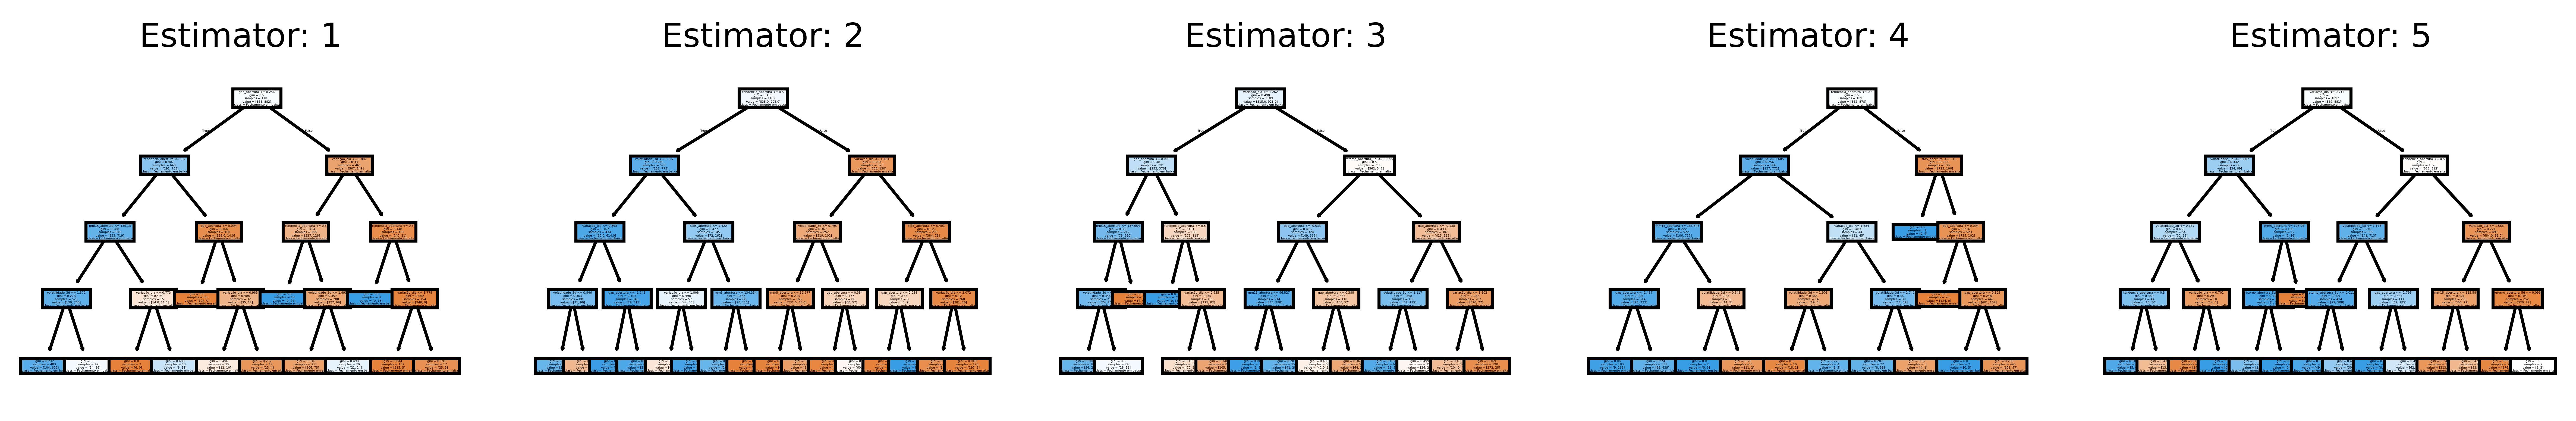

In [61]:
# Visualizando arvores de decisão do modelo
class_names = ['Fechamento em alta', 'Fechamento em baixa']
label_names = list(x.columns)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,2), dpi=800)

for index in range(0,5):
  tree.plot_tree(rf.estimators_[index],
                 feature_names=label_names,
                 class_names=class_names,
                 filled=True,
                 ax = axes[index]);

  axes[index].set_title('Estimator: ' + str(index+1), fontsize=11)


### VALIDANDO MODELO

#### VALIDAÇÃO CRUZADA

In [62]:
# Embaralhando dados e rodando testes
kfold = KFold(n_splits=5, shuffle=True )
result_cross_val_rf = cross_val_score(rf, x, y, cv=kfold, scoring='accuracy')

# Exibindo resultados
print("Scores de cada fold:", result_cross_val_rf)
print("R² médio: {:.2f}%".format(result_cross_val_rf.mean() * 100))
print("Desvio padrão: {:.2f}%".format(result_cross_val_rf.std() * 100))

Scores de cada fold: [0.84538153 0.8313253  0.84909457 0.84708249 0.84708249]
R² médio: 84.40%
Desvio padrão: 0.64%


É possível concluir que rodando o algoritimo em cenários diferentes e aleatórios, a acuracidade se mantém alta

### VISUALIZANDO MÉTRICAS DE VALIDAÇÃO

In [63]:
# Métricas de validação
probs_rf = rf.predict_proba(x_test)[:, 1]
accuracy_rf = accuracy_score(y_test, y_pred_rf)
reports_rf = classification_report(y_test, y_pred_rf)
matriz_rf = confusion_matrix(y_test, y_pred_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, probs_rf)
roc_auc = auc(fpr_rf, tpr_rf)
importances_rf = rf.feature_importances_

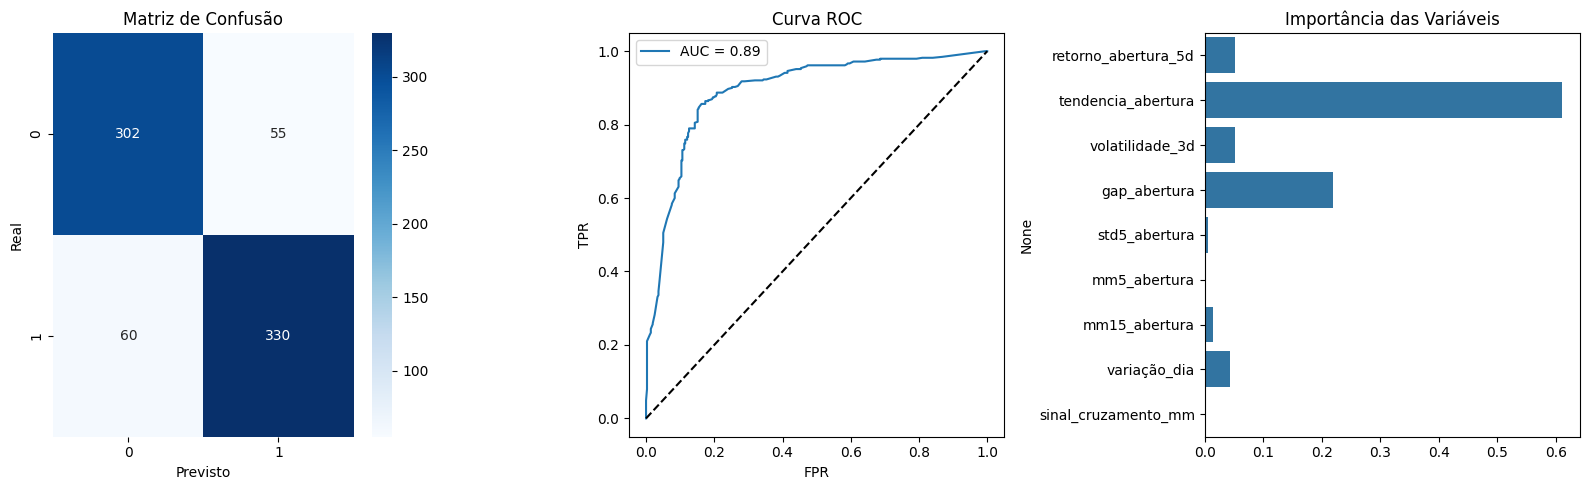

In [64]:
# Gráficos de validação do modelo
plt.figure(figsize=(16, 5))

# Matriz de confusão
plt.subplot(1, 3, 1)
sns.heatmap(matriz_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')

# Curva ROC
plt.subplot(1, 3, 2)
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# Importância das variáveis
plt.subplot(1, 3, 3)
sns.barplot(x=importances_rf, y=x.columns)
plt.title('Importância das Variáveis')

plt.tight_layout()
plt.show()

In [65]:
print(reports_rf)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       357
           1       0.86      0.85      0.85       390

    accuracy                           0.85       747
   macro avg       0.85      0.85      0.85       747
weighted avg       0.85      0.85      0.85       747



### KNN

In [66]:
# Dividindo dados entre treino e teste por uma seed aleatória
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [67]:
# Instanciando e treinando modelo
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean', weights='distance')
knn.fit(x_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='distance')

In [68]:
# Rodando modelo
y_pred_knn = knn.predict(x_test)

In [69]:
# Validando modelo
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print('Acurracy: {:.2f}'.format(round(accuracy_knn, 2)))

Acurracy: 0.76


### VALIDANDO MODELO

#### VALIDAÇÃO CRUZADA

In [70]:
# Embaralhando dados e rodando testes
kfold = KFold(n_splits=5, shuffle=True )
result_cross_val_knn = cross_val_score(knn, x, y, cv=kfold, scoring='accuracy')

# Exibindo resultados
print("Scores de cada fold:", result_cross_val_knn)
print("R² médio: {:.2f}%".format(result_cross_val_knn.mean() * 100))
print("Desvio padrão: {:.2f}%".format(result_cross_val_knn.std() * 100))

Scores de cada fold: [0.76305221 0.75702811 0.75050302 0.75855131 0.78269618]
R² médio: 76.24%
Desvio padrão: 1.09%


### VISUALIZANDO MÉTRICAS DE VALIDAÇÃO

In [71]:
# Métricas de validação
probs_knn = knn.predict_proba(x_test)[:, 1]
accuracy_knn = accuracy_score(y_test, y_pred_knn)
reports_knn = classification_report(y_test, y_pred_knn)
matriz_knn = confusion_matrix(y_test, y_pred_knn)
fpr_knn, tpr_knn, _ = roc_curve(y_test, probs_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
importances_knn = importances = rf.feature_importances_

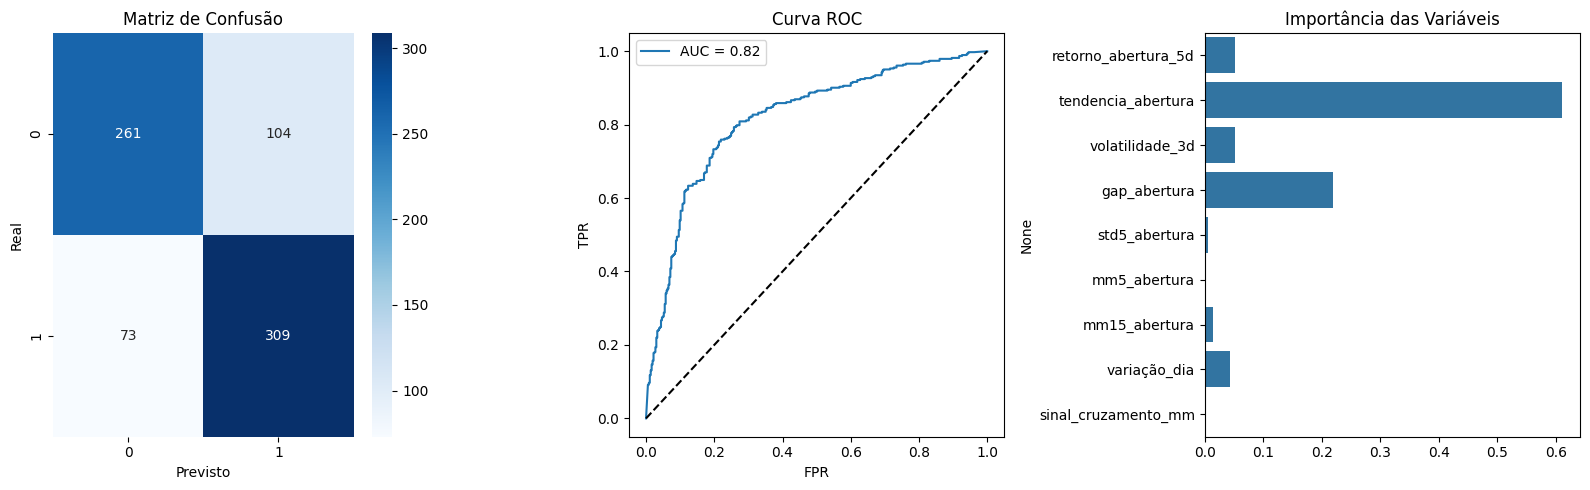

In [72]:
# Gráficos de validação do modelo
plt.figure(figsize=(16, 5))

# Matriz de confusão
plt.subplot(1, 3, 1)
sns.heatmap(matriz_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')

# Curva ROC
plt.subplot(1, 3, 2)
plt.plot(fpr_knn, tpr_knn, label=f'AUC = {roc_auc_knn:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# Importância das variáveis
plt.subplot(1, 3, 3)
sns.barplot(x=importances_knn, y=x.columns)
plt.title('Importância das Variáveis')

plt.tight_layout()
plt.show()

In [73]:
print(reports_knn)

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       365
           1       0.75      0.81      0.78       382

    accuracy                           0.76       747
   macro avg       0.76      0.76      0.76       747
weighted avg       0.76      0.76      0.76       747



### COMPARANDO MODELOS

In [74]:
dict_models = {
    'GNB': result_cross_val_gnb.mean(),
    'RF': result_cross_val_rf.mean(),
    'KNN': result_cross_val_knn.mean()
}

In [75]:
# Selecionando melhor modelo
MelhorModelo = max(dict_models, key=dict_models.get)

print('GNB: {0:.2f}\nRF: {1:.2f}\nKNN: {2:.2f}'.format(result_cross_val_gnb.mean(), result_cross_val_rf.mean(), result_cross_val_knn.mean()))
print('O Melhor modelo é: {} com o valor: {:.2f} de acuracidade'.format(MelhorModelo, dict_models[MelhorModelo]))

GNB: 0.84
RF: 0.84
KNN: 0.76
O Melhor modelo é: RF com o valor: 0.84 de acuracidade


Foi escolhido como melhor modelo o **Random Forest**, por ter uma importancia mais balanceada entre as variáveis e apresentar uma curva ROC melhor

### EXECUTANDO MODELO NOS ULTIMOS 30 DIAS DA BASE

In [76]:
df_ultimos_30d = df[:30]

In [77]:
df_ultimos_30d.shape

(30, 26)

In [78]:
# Separando variáveis indepentes e target

x_ultimos_30d = df_ultimos_30d[list(x.columns)]
y_ultimos_30d = df_ultimos_30d['Class']

In [79]:
# Rodando modelo
y_pred_rf_30d = rf.predict(x_ultimos_30d)

In [80]:
# Validando modelo
accuracy_rf_30d = accuracy_score(y_ultimos_30d, y_pred_rf_30d)

print('Acurracy: {:.2f}'.format(accuracy_rf_30d))
#print(classification_report(y_test, y_pred))

Acurracy: 0.80


In [81]:
# Métricas de validação
probs_rf_30d = rf.predict_proba(x_ultimos_30d)[:, 1]
accuracy_rf_30d = accuracy_score(y_ultimos_30d, y_pred_rf_30d)
reports_rf_30d = classification_report(y_ultimos_30d, y_pred_rf_30d)
matriz_rf_30d = confusion_matrix(y_ultimos_30d, y_pred_rf_30d)
fpr_rf_30d, tpr_rf_30d, _ = roc_curve(y_ultimos_30d, probs_rf_30d)
roc_auc = auc(fpr_rf_30d, tpr_rf_30d)
importances_rf_30d = rf.feature_importances_

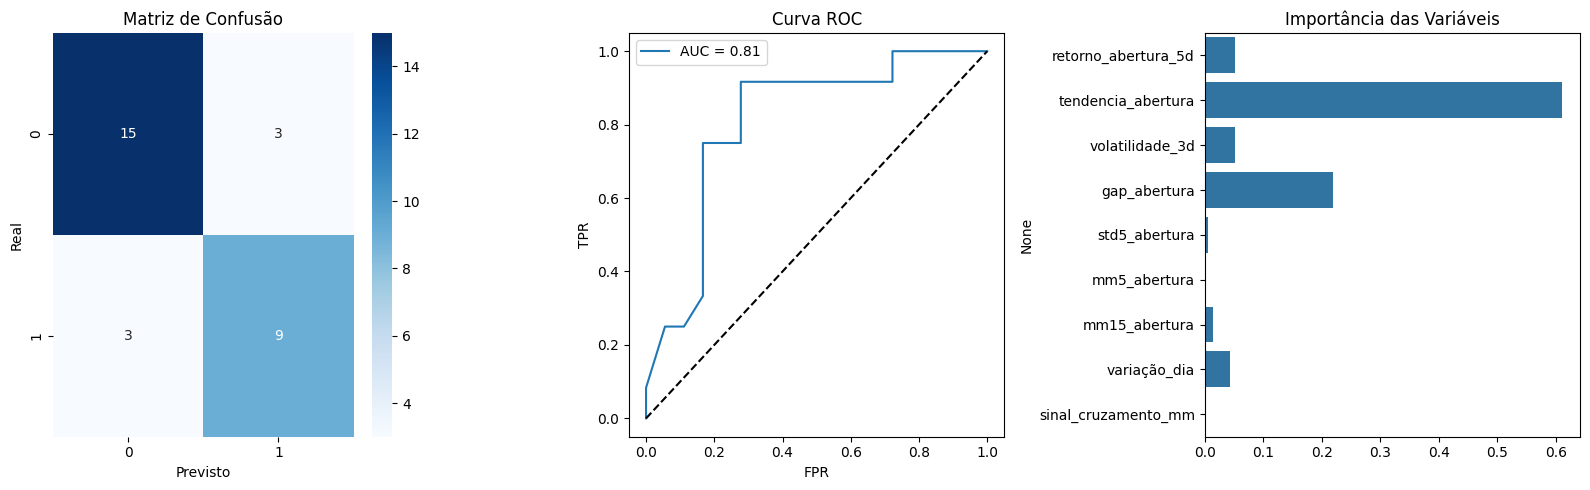

In [82]:
# Gráficos de validação do modelo
plt.figure(figsize=(16, 5))

# Matriz de confusão
plt.subplot(1, 3, 1)
sns.heatmap(matriz_rf_30d, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')

# Curva ROC
plt.subplot(1, 3, 2)
plt.plot(fpr_rf_30d, tpr_rf_30d, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# Importância das variáveis
plt.subplot(1, 3, 3)
sns.barplot(x=importances_rf_30d, y=x.columns)
plt.title('Importância das Variáveis')

plt.tight_layout()
plt.show()

In [83]:
print(reports_rf_30d)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.75      0.75      0.75        12

    accuracy                           0.80        30
   macro avg       0.79      0.79      0.79        30
weighted avg       0.80      0.80      0.80        30

